In [2]:
import librosa
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import os


# File structuring

First, set up the `DATA_ROOT`

In [3]:
DATA_ROOT = '../data/openmic-2018/'

if not os.path.exists(DATA_ROOT):
    raise ValueError('Did you forget to set `DATA_ROOT`?')

Load the `OPENMIC` dataset

In [4]:
import numpy as np
OPENMIC = np.load(os.path.join(DATA_ROOT, 'openmic-2018.npz'), allow_pickle=True)

The contents of the dataset is described in detail on the [OPENMIC's Official Github](https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb). It contains VGGish features, which are to be excluded, as we want to replicate the analysis of [Predominant Musical Instrument Classification based on Spectral Features
](https://arxiv.org/abs/1912.02606) (PMICSF).

In [5]:
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']

# Feature extraction
The goal is to replicate the approach of [PMICSF](https://arxiv.org/abs/1912.02606). The features used in the article are:

* **Zero Crossing Rate** (ZCR):  indicates the rate at which the signal crosses zero.
* **Spectral Centroid** (SC): a metric that indicate the center of mass of the spectrum being located. It is *"the ratio of the frequency weighted magnitude spectrum with unweighted magnitude spectrum"*
* **Spectral Bandwidth** (SB): gives the weighted average of the frequency signal by its spectrum.
* **Spectral roll-off** (SR):  the frequency under which a certain proportion of the overall spectral energy belongs to
* **MFCC**: the meaon of the first 13 MFCC features.

We intend to  calculate these features for the `OPENMIC` dataset, and store them in a Panda's Dataframe ordered by sample key. The sample keys are available in the `sample_key` list produced in the code block above.


> **Question**: what did they use on Librosa? Same?

From PMICSF, page 3:

>  The audio spectrum is analyzed by extracting MFCCs based on the default inputs of hopSize (hop length between frames) and frame size. The default parameters for sampling rate is 44.1 kHz, **hopSize of 512** and **frame size of 1024** in Essentia

For convinience, and according to [Presets](https://librosa.org/blog/2019/07/17/resample-on-load/), we set the default parameters of Librosa to match those values. 

In [6]:
# first define the default values to match PMICSF
# TODO: why import it as _librosa?
from presets import Preset
import librosa as _librosa
librosa = Preset(_librosa)
librosa['n_fft'] = 2048
librosa['win_length'] = 1024
librosa['hop_length'] = 512

To find all audio files in the dataset, Librosa's util function [find_files](https://librosa.org/doc/main/generated/librosa.util.find_files.html) was used:

In [7]:
import librosa as lr
import pandas as pd

file_paths = lr.util.find_files(DATA_ROOT + "audio", ext="ogg")
index = pd.DataFrame({"file_path": file_paths, "sample_key": sample_key})
index

,file_path,sample_key
0,/workspaces/instrument-detection/data/openmic-...,000046_3840
1,/workspaces/instrument-detection/data/openmic-...,000135_483840
2,/workspaces/instrument-detection/data/openmic-...,000139_119040
3,/workspaces/instrument-detection/data/openmic-...,000141_153600
4,/workspaces/instrument-detection/data/openmic-...,000144_30720
...,...,...
19995,/workspaces/instrument-detection/data/openmic-...,155294_184320
19996,/workspaces/instrument-detection/data/openmic-...,155295_76800
19997,/workspaces/instrument-detection/data/openmic-...,155307_211200
19998,/workspaces/instrument-detection/data/openmic-...,155310_372480


In [8]:
index['file_path'].head()

0    /workspaces/instrument-detection/data/openmic-...
1    /workspaces/instrument-detection/data/openmic-...
2    /workspaces/instrument-detection/data/openmic-...
3    /workspaces/instrument-detection/data/openmic-...
4    /workspaces/instrument-detection/data/openmic-...
Name: file_path, dtype: object

Next step is to preprocess all files and extract all features. For efficiancy, we used Spotify's [Pedalboard](https://github.com/spotify/pedalboard) for loading audio and Librosas Feature package for feature extraction. Below is what packages we used:

* ZCR: [librosa.feature.zero_crossing_rate](https://librosa.org/doc/main/generated/librosa.feature.zero_crossing_rate.html)
* SC: [librosa.feature.spectral_centroid](https://librosa.org/doc/main/generated/librosa.feature.spectral_centroid.html)
* SB: [librosa.feature.spectral_bandwidth](https://librosa.org/doc/main/generated/librosa.feature.spectral_bandwidth.html)
* SR: [librosa.feature.spectral_rolloff](https://librosa.org/doc/main/generated/librosa.feature.spectral_rolloff.html)

The article also extracts the mean of the first 13 MFCC features with Librosa:

> We extracted the first 13 MFCC features using Librosa/Essentia. For each audio clip, we obtained 259 × 13 matrix features. **We took the mean of all the columns to get the condensed feature** providing us with 1 × 13 feature vector, along with five other features as mentioned above. We labeled each vector with the instrument class using scikit- learn’s ‘labelencoder’ function.

In [9]:
from turtle import ycor
import pedalboard as pb
import librosa as lr


def preprocess(index):
    """
    Preprocess audio and extract features according to PMICSF
    Input: an audiofile
    Returns: a dictionary with zcrs, scs, mfccs
    """
    features = {}
    with pb.io.AudioFile(index[0]) as f:
        # TODO so some files have varying SR, which could be problematic
        #assert f.samplerate == 44100, f"Sample rate is not 44.1khz for {file}!"
        # TODO count _one_ spectogram and then use as input to all features
        y = f.read(f.frames)
        y = y.mean(axis=0)  # mono
        # To speed up calculation, calculate one spectogram
        # TODO is this right, and does the standard values as defined above really hold?
        S = np.abs(librosa.stft(y))**2
        zcrs = librosa.feature.zero_crossing_rate(y=y)
        features["sample_key"] = index[1]
        features["zcr_mean"] = zcrs.mean()
        features["zcr_std"] = zcrs.std()
        scs = librosa.feature.spectral_centroid(S=S)
        features["sc_mean"] = scs.mean()
        features["sc_std"] = scs.std()
        sbs = librosa.feature.spectral_bandwidth(S=S)
        features["sb_mean"] = sbs.mean()
        features["sb_std"] = sbs.std()
        srs = librosa.feature.spectral_rolloff(S=S)
        features["sr_mean"] = sbs.mean()
        features["sr_std"] = sbs.std()
        mfccs = librosa.feature.mfcc(S=S, n_mfcc=13)
        for i, mfcc in enumerate(mfccs):
            features['mfcc' + str(i+1) + '_mean'] = mfcc.mean()
            features['mfcc' + str(i+1) + 'std'] = mfcc.std()

    return features



The audio files were preprocessed in parallell, using Python's [multiprocess](https://docs.python.org/3/library/multiprocessing.html) package.

> **NOTE:** if using the enclosed `.devcontainer`, make sure to adjust the RAM and available cores in your Docker settings. Not doing so will render the kernel to crash! We used 4gb ram and 6 cores on a MacBook Air M1, leading to a calculation time of roughly 10 minutes. 

In [10]:
from tqdm import tqdm
import numpy as np

from multiprocessing import Pool

if not os.path.exists('features.csv'):
    with Pool() as p:
        # index.values.tolist() returns a list with [file_path, sample_key]
        ys = list(tqdm(p.imap(preprocess, index.values.tolist()), total=len(index)))
        ys = pd.DataFrame(ys)
        ys = ys.set_index("sample_key")
else:
    ys = pd.read_csv('features.csv', index_col="sample_key")
    #ys.drop(columns="Unnamed: 0")
    


I think we want to store the features in a csv file

In [11]:
if not os.path.exists('features.csv'):
    pd.DataFrame(ys).to_csv('features.csv')
else:
    print("Features already calculated and stored in features.csv")

Features already calculated and stored in features.csv



# Labeling
> **NOTERING**: Se även [test.ipynb](/src/test.ipynb)

From PMICSF part C, *Classifier Training*

> We labeled each vector with the instrument class using scikitlearn’s ‘labelencoder’ function

> **Question**: not sure how they use [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

The team behind OPENMIC has made a good split of the data, and most of the following code is from their [tutorial on GitHub](https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb).

In [12]:
# Let's split the data into the training and test set
# We use squeeze=True here to return a single array for each, rather than a full DataFrame

split_train = pd.read_csv(
    os.path.join(DATA_ROOT, "partitions/split01_train.csv"), header=None, squeeze=True
)
split_test = pd.read_csv(
    os.path.join(DATA_ROOT, "partitions/split01_test.csv"), header=None, squeeze=True
)

split_test.head()

/tmp/ipykernel_9662/2913080075.py:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  split_train = pd.read_csv(
/tmp/ipykernel_9662/2913080075.py:7: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  split_test = pd.read_csv(


0      000178_3840
1     000308_61440
2    000312_184320
3    000319_145920
4    000321_218880
Name: 0, dtype: object

In [13]:
# How many train and test examples do we have?  About 75%/25%
print("# Train: {},  # Test: {}".format(len(split_train), len(split_test)))

# Train: 14915,  # Test: 5085


In [14]:
# convert df to set
train_set = set(split_train)
test_set = set(split_test)

In [15]:
# These loops go through all sample keys, and save their row numbers
# to either idx_train or idx_test
#
# This will be useful in the next step for slicing the array data
idx_train, idx_test = [], []

for idx, n in enumerate(sample_key):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError("Unknown sample key={}! Abort!".format(sample_key[n]))

# Finally, cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

From OPENMIC tutorial:

> For convenience, we provide a simple JSON object that maps class indices to names.

In [16]:
import json

with open(os.path.join(DATA_ROOT, 'class-map.json'), 'r') as f:
    class_map = json.load(f)
class_map

{'accordion': 0,
 'banjo': 1,
 'bass': 2,
 'cello': 3,
 'clarinet': 4,
 'cymbals': 5,
 'drums': 6,
 'flute': 7,
 'guitar': 8,
 'mallet_percussion': 9,
 'mandolin': 10,
 'organ': 11,
 'piano': 12,
 'saxophone': 13,
 'synthesizer': 14,
 'trombone': 15,
 'trumpet': 16,
 'ukulele': 17,
 'violin': 18,
 'voice': 19}

In [17]:
data_train = Y_mask[idx_train]
data_test = Y_mask[idx_train]
sample_key_train = sample_key[idx_train]  # numpy.ndarray
sample_key_test = sample_key[idx_test]

type(sample_key_train)

numpy.ndarray

In [18]:
# Finally, we use the split indices to partition the features, labels, and masks
X_train = X[idx_train]
X_test = X[idx_test]

Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]

Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]

In [22]:
# sandbox
#print(Y_true[40])
#print(Y_mask[40])
#tmp_dict = dict(zip(class_map, Y_true[40] * Y_mask[40]))

dict(zip(class_map, Y_mask[40] * Y_true[40]))

print(type(Y_mask))
bool_to_NaN = lambda x: np.NaN if x == False else x
NaN_mask = map(bool_to_NaN, Y_mask[40])
list(NaN_mask)*Y_true[40]

<class 'numpy.ndarray'>


array([    nan,     nan,     nan,     nan,     nan, 0.15055,     nan,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan])

In [23]:
def generate_dataframe_with_labels(indices, class_map, Y_mask, Y_true):
    """
    A method for creating a pd.df with each label in Y_mask and instrument in class_map
    Requires sorting of indices first (idx_train and idx_test) as explained in OPENMIC2018 tutorial
    """
    data = {}
    for i in indices:
        # NOTE: after spending some time on reading the openmic-2018 tutorial, I believe this is a good way to remove
        # labels. If the label is NaN, there is no observations for it and thus cannot be used for training.
        bool_to_NaN = lambda x: np.NaN if x == False else x
        NaN_mask = list(map(bool_to_NaN, Y_mask[i]))
        tmp_dict = dict(zip(class_map, Y_true[i] * NaN_mask))
        data[sample_key[i]] = tmp_dict

    return pd.DataFrame.from_dict(data, orient="index")

Using the util function above, we create a big table with all the labels, as predicted by the OPENMIC team.

In [24]:
# set up dataframes with sample key and correct label
df_train = generate_dataframe_with_labels(idx_train, class_map, Y_mask, Y_true)
df_test = generate_dataframe_with_labels(idx_test, class_map, Y_mask, Y_true)

df_train.head()

,accordion,banjo,bass,cello,clarinet,cymbals,drums,flute,guitar,mallet_percussion,mandolin,organ,piano,saxophone,synthesizer,trombone,trumpet,ukulele,violin,voice
000046_3840,NaN,NaN,NaN,NaN,0.17105,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
000135_483840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14705,NaN,NaN,0.0,NaN,NaN,1.0
000139_119040,0.84485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000141_153600,0.83820,NaN,NaN,NaN,0.17840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000144_30720,0.16215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


Should we perhaps *merge* the tables together or is this OK?

In [25]:
ys.head()

,zcr_mean,zcr_std,sc_mean,sc_std,sb_mean,sb_std,sr_mean,sr_std,mfcc1_mean,mfcc1std,...,mfcc9_mean,mfcc9std,mfcc10_mean,mfcc10std,mfcc11_mean,mfcc11std,mfcc12_mean,mfcc12std,mfcc13_mean,mfcc13std
sample_key,,,,,,,,,,,,,,,,,,,,,
000046_3840,0.036367,0.021923,296.517136,133.109808,288.159666,267.139540,288.159666,267.139540,147.18806,178.52283,...,166.07562,216.15845,158.76860,209.78517,151.586730,203.43971,144.20024,197.13676,136.57768,190.80775
000135_483840,0.052411,0.013491,478.192757,141.199973,409.844515,135.532246,409.844515,135.532246,1282.76940,310.55603,...,765.03280,495.68510,590.32880,558.75824,425.313660,616.81950,274.80215,663.55350,142.18160,694.35410
000139_119040,0.081234,0.014925,604.505859,189.731508,719.222449,139.070343,719.222449,139.070343,292.69028,238.36676,...,214.49968,316.38672,198.65715,314.67343,186.793670,313.87470,177.73270,313.87650,170.00764,313.99084
000141_153600,0.053718,0.013248,462.825122,153.244140,391.783679,84.894649,391.783679,84.894649,188.99663,116.76610,...,146.75562,140.59268,130.84398,137.76826,116.143745,135.27222,102.52170,133.01720,89.94732,130.88220
000144_30720,0.082449,0.034076,601.706717,329.074617,766.763811,375.408621,766.763811,375.408621,196.93245,202.77621,...,172.74915,268.45245,166.11035,266.88522,159.133510,265.19022,151.69370,263.76523,143.99810,262.70773


In [ ]:
df_train = df_train.join(ys)
df_train.to_csv("train.csv")
df_test = df_test.join(ys)
df_test.to_csv("test.csv")


In [ ]:
df_train.head()


,accordion,banjo,bass,cello,clarinet,cymbals,drums,flute,guitar,mallet_percussion,...,mfcc9_mean,mfcc9std,mfcc10_mean,mfcc10std,mfcc11_mean,mfcc11std,mfcc12_mean,mfcc12std,mfcc13_mean,mfcc13std
000046_3840,0.00000,0.0,0.0,0.0,0.17105,0.0,0.0,0.0,0.0,0.0,...,166.07562,216.15845,158.76860,209.78517,151.586730,203.43971,144.20024,197.13676,136.57768,190.80775
000135_483840,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,765.03280,495.68510,590.32880,558.75824,425.313660,616.81950,274.80215,663.55350,142.18160,694.35410
000139_119040,0.84485,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,214.49968,316.38672,198.65715,314.67343,186.793670,313.87470,177.73270,313.87650,170.00764,313.99084
000141_153600,0.83820,0.0,0.0,0.0,0.17840,0.0,0.0,0.0,0.0,0.0,...,146.75562,140.59268,130.84398,137.76826,116.143745,135.27222,102.52170,133.01720,89.94732,130.88220
000144_30720,0.16215,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,172.74915,268.45245,166.11035,266.88522,159.133510,265.19022,151.69370,263.76523,143.99810,262.70773


In [ ]:
# TODO sk multilearn
instruments = list(class_map.keys())
instruments

['accordion',
 'banjo',
 'bass',
 'cello',
 'clarinet',
 'cymbals',
 'drums',
 'flute',
 'guitar',
 'mallet_percussion',
 'mandolin',
 'organ',
 'piano',
 'saxophone',
 'synthesizer',
 'trombone',
 'trumpet',
 'ukulele',
 'violin',
 'voice']

In [ ]:
df_train.columns

Index(['accordion', 'banjo', 'bass', 'cello', 'clarinet', 'cymbals', 'drums',
       'flute', 'guitar', 'mallet_percussion', 'mandolin', 'organ', 'piano',
       'saxophone', 'synthesizer', 'trombone', 'trumpet', 'ukulele', 'violin',
       'voice', 'Unnamed: 0', 'zcr_mean', 'zcr_std', 'sc_mean', 'sc_std',
       'sb_mean', 'sb_std', 'sr_mean', 'sr_std', 'mfcc1_mean', 'mfcc1std',
       'mfcc2_mean', 'mfcc2std', 'mfcc3_mean', 'mfcc3std', 'mfcc4_mean',
       'mfcc4std', 'mfcc5_mean', 'mfcc5std', 'mfcc6_mean', 'mfcc6std',
       'mfcc7_mean', 'mfcc7std', 'mfcc8_mean', 'mfcc8std', 'mfcc9_mean',
       'mfcc9std', 'mfcc10_mean', 'mfcc10std', 'mfcc11_mean', 'mfcc11std',
       'mfcc12_mean', 'mfcc12std', 'mfcc13_mean', 'mfcc13std'],
      dtype='object')

In [ ]:
df_train.loc["006463_157440"]

accordion              0.000000
banjo                  0.000000
bass                   0.000000
cello                  0.000000
clarinet               0.000000
cymbals                0.000000
drums                  0.000000
flute                  0.000000
guitar                 0.000000
mallet_percussion      0.000000
mandolin               0.000000
organ                  0.000000
piano                  0.000000
saxophone              1.000000
synthesizer            0.000000
trombone               1.000000
trumpet                0.810350
ukulele                0.000000
violin                 0.000000
voice                  0.000000
Unnamed: 0           664.000000
zcr_mean               0.041517
zcr_std                0.017478
sc_mean              298.470300
sc_std               117.051830
sb_mean              398.207726
sb_std               214.714994
sr_mean              398.207726
sr_std               214.714994
mfcc1_mean           292.609070
mfcc1std             263.161130
mfcc2_me

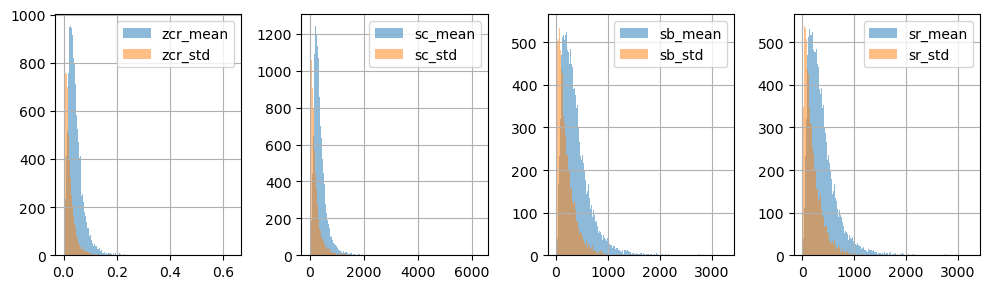

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
df_train["zcr_mean"].hist(bins=200, alpha = 0.5, legend = True, ax = axes[0])
df_train["zcr_std"].hist(bins=200, alpha = 0.5, legend = True, ax = axes[0])

df_train["sc_mean"].hist(bins=200, alpha = 0.5, legend = True, ax = axes[1])
df_train["sc_std"].hist(bins=200, alpha = 0.5, legend = True, ax = axes[1])

df_train["sb_mean"].hist(bins=200, alpha = 0.5, legend = True, ax = axes[2])
df_train["sb_std"].hist(bins=200, alpha=0.5, legend = True, ax = axes[2])

df_train["sr_mean"].hist(bins=200, alpha = 0.5, legend = True, ax = axes[3])
df_train["sr_std"].hist(bins=200, alpha = 0.5, legend = True, ax = axes[3])

plt.tight_layout()

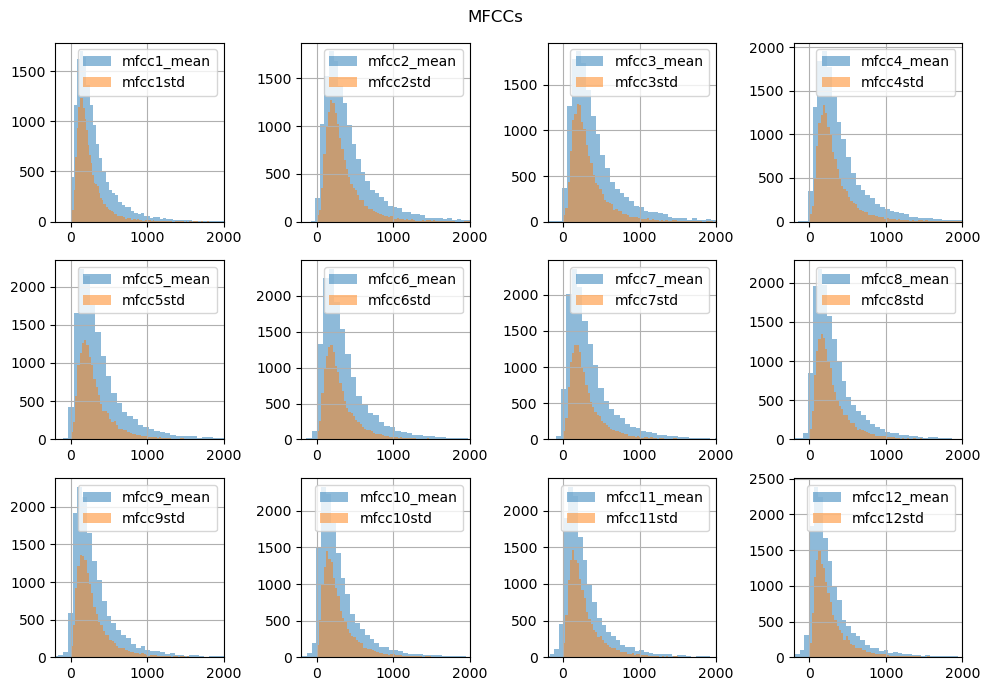

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(10, 7), sharex=False)

for i in range(3):
    for j in range(4):
        df_train["mfcc{}_mean".format(i*4+j+1)].hist(bins=200, alpha = 0.5, legend = True, ax = axes[i][j])
        df_train["mfcc{}std".format(i*4+j+1)].hist(bins=200, alpha = 0.5, legend = True, ax = axes[i][j])

fig.suptitle("MFCCs")

# set the x axis to a limit of [-200, 2000] for all plots
for i in range(3):
    for j in range(4):
        axes[i][j].set_xlim([-200, 2000])
        
plt.tight_layout()